In [123]:
# import das libs necessarias

import pandas as pd # trabalhar com dataframes
import numpy as np # realizacao de algumas operacoes com matrizes

#imagens
import cv2 # transformacoes faceis em imagens
from PIL import Image # trabalhar com imagens

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
# ferramentais
import glob # exploracao de diretorios
from pylab import *
import random

# plot 
import matplotlib.pyplot as plt # plotagem
%matplotlib inline

In [124]:
# itera por cada imagem  adicionando a classe de acordo com o nome da img
imagePaths = glob.glob(r"../data/sample/*")
IMG_SIZE = 400
X = []
Y = []
num_sample = 300
count = 0
for img in imagePaths:
    if count > num_sample:
        break
    img_data = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    img_data = cv2.resize(img_data, (IMG_SIZE, IMG_SIZE))
    X.append([np.array(img_data)])
    Y.append(0 if "cat" in img else 1)
    count += 1

In [125]:
# prepara dataframe xom img e classe
X= np.array([i[0] for i in X]).reshape(-1, IMG_SIZE, IMG_SIZE)
X = np.array([i.flatten() for i in X])

# Prepara Dataframes
X = pd.DataFrame(X)
Y = pd.DataFrame(Y)

---

Precisamos criar um classificador simples para poder otimizar com o GA, vamos iniciar ocm um simples random forest como baseline

In [126]:
# Divide em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25, random_state = 42)
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (225, 160000)
Training Labels Shape: (225, 1)
Testing Features Shape: (76, 160000)
Testing Labels Shape: (76, 1)


In [127]:
# Criando classificador baseline
rf = RandomForestClassifier(n_estimators = 7, random_state = 42)
rf.fit(X_train, np.ravel(y_train));

In [128]:
# Fazendo predicoes baseline
preds = rf.predict(X_test)
score = roc_auc_score(y_test, preds)
print ("Baseline AUC {}".format(score))

Baseline AUC 0.6416666666666667


Nos ja esperavamos um baseline nao tao bom, vamos tentar utilizar feature selection para melhorar ou manter o AUC com menos features

---

# Algoritmo Genetico

Vamos utilizar algoritmo genetico para trabalhar as features de X tentando otimizar a AUC tentando seleciona-las

In [194]:
from importlib import reload
import feature_selection_GA as GA
reload(GA)

<module 'feature_selection_GA' from '/home/fernando.favoretti/src/personal/pattern_recognition/feature_selection/feature_selection_GA.py'>

In [206]:
%%time

# Setamos parametros para o algoritmo genetico
pop_size = 10
cols_per_pop = 1600
num_generations = 1000
num_parents_mating = 4

# rodamos o algoritmo
final_cols = GA.optimize_ga(X_train, y_train,
            X_test, y_test,
            pop_size,
            cols_per_pop,
            num_generations,
            num_parents_mating)

Optimizing with 1000 generations
Generation 0
Best result : 0.5763888888888888
Generation 1
Best result : 0.6305555555555555
Generation 2
Best result : 0.6402777777777777
Generation 3
Best result : 0.6819444444444444
Generation 4
Best result : 0.6819444444444444
Generation 5
Best result : 0.6819444444444444
Generation 6
Best result : 0.6819444444444444
Generation 7
Best result : 0.6819444444444444
Generation 8
Best result : 0.6819444444444444
Generation 9
Best result : 0.6819444444444444
Generation 10
Best result : 0.6819444444444444
Generation 11
Best result : 0.6819444444444444
Generation 12
Best result : 0.6819444444444444
Generation 13
Best result : 0.6819444444444444
Generation 14
Best result : 0.6819444444444444
Generation 15
Best result : 0.6819444444444444
Generation 16
Best result : 0.6819444444444444
Generation 17
Best result : 0.6819444444444444
Generation 18
Best result : 0.6819444444444444
Generation 19
Best result : 0.6819444444444444
Generation 20
Best result : 0.6819444

In [209]:
# predicao final com as colunas escolhidas pelo algoritmo
GA_X_train = X_train[final_cols]
GA_X_test = X_test[final_cols]

In [211]:
# Criando classificador baseado no algoritmo
rf = RandomForestClassifier(n_estimators = 7, random_state = 42)
rf.fit(GA_X_train, np.ravel(y_train));

# Fazendo novas predicoes
preds = rf.predict(GA_X_test)
score = roc_auc_score(y_test, preds)
print ("Final AUC {}".format(score))

Final AUC 0.7347222222222223


Vemos que apos 1000 geracoes do algoritmo genetico chegamos a um modelo mais inxuto e com melhor performance utilizando apenas 10% das colunas originais do dataset

Vamos plotar 10 imagens para ver se o classificador separou algo humanamente visivel

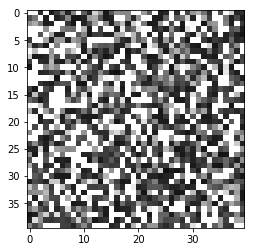

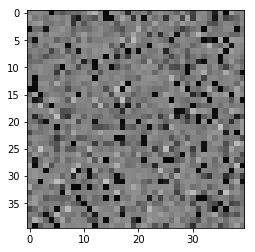

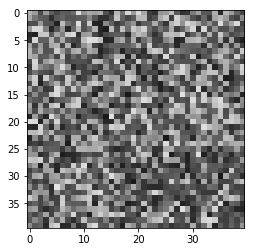

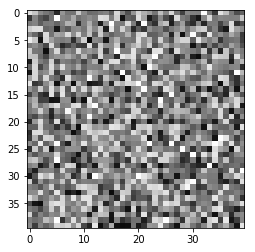

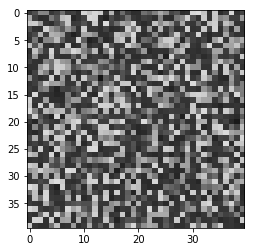

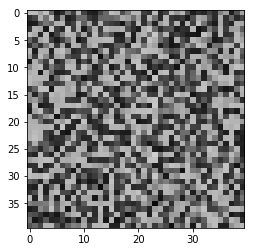

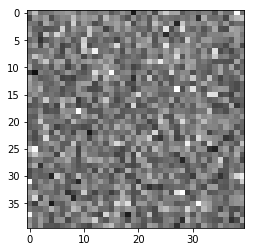

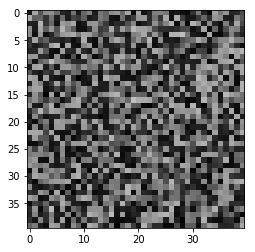

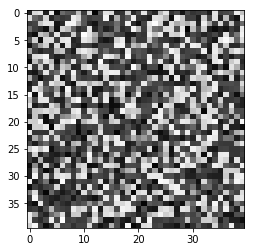

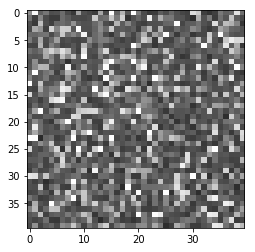

In [252]:
for i in range(10):
    fig = GA_X_train.iloc[i].values
    # 1600 colunas equivale a uma imagem de 40x40
    img = Image.fromarray(fig.reshape(40,40))
    plt.figure()
    plt.imshow(img)  
